# Developing Annotation Pipeline for Carbohydrate-Active Enzymes in Bacterial Genomes
Author: Xin (David) Zhao
Creation Date: August 19, 2024 

## Workflow (https://chatgpt.com/share/0a1b1e4c-fabc-4e76-95ff-e8a68b7db817) updated August 22, 2024 
1. Install required packages 
2. Download CAZyme database 
3. Load the bacterial genome 
4. Predict genes (if not available)
5. Align predicted proteins with CAZyme profiles 
6. Parse HMMER output in Python 
7. Annotate genome with CAZyme information 
8. Visualization and reporting  
9.  Pipeline automation 
10. Validation and testing 
11. Documentation       


In [4]:
# Downlaod and install the latest version of the NCBI CLI.
# Download datasets: curl -o datasets 'https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/v2/mac/datasets' 
# Download dataformat: curl -o dataformat 'https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/v2/mac/dataformat'
# Make them executable: chmod +x datasets 

In [5]:
# Download genome data for strains of L. reuteri 
# Strains: LTH2584, TMW1.112, TMW1.656, LTH5448, 100-23, lpuph, and mlc3 
# The Submitted GenBank assembly accession numbers are: GCA_000712555.1 ... 

# Download the genome data for L. reuteri strain LTH2584
datasets download genome accession GCA_000712555.1 --filename reuteri_GCF_000007225_dataset.zip

SyntaxError: invalid syntax (1483170219.py, line 6)

In [ ]:
# Step 1: Install required packages in terminal 
# pip install biopython 
# pip install pandas 
# pip install requests 


In [6]:
# Step 2: Download HMMER database from dbCAN 
# Download the HMMER database from dbCAN using the following command: 

import requests

# URL of the text file 
url = 'http://bcb.unl.edu/dbCAN2/download/dbCAN-HMMdb-V9.txt'

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful 
if response.status_code == 200:
    # Save the text file to the current directory
    with open('dbCAN-HMMdb-V9.txt', 'wb') as file:
        file.write(response.content)
    print('HMMER database downloaded successfully!')
else:
    print(f'Failed to download HMMER database! Status code: {response.status_code}')




HMMER database downloaded successfully!


In [7]:
# Load the bacterial genome
# %pip install biopython 
from Bio import SeqIO

fna_file = "reuteri_GCF_000007225_dataset/ncbi_dataset/data/GCA_000712555.1/GCA_000712555.1_LTH2584_genomic.fna" 

# Read all records from the FASTA file
genome_seqs = list(SeqIO.parse(fna_file, "fasta"))

print(len(genome_seqs)) # Number of records in the FASTA file 

# Select the first record
genome_seq = genome_seqs[0]


25


In [ ]:
# Step 5: Predict genes using prodigal (Prokaryotic Dynamic Programming Gene-finding Algorithm) 

# Install prodigal in the terminal 
brew isntall prodigal 
prodigal -v 

In [ ]:
# If a gene prediction file (GFF) is not available, use prodigal to predict genes 
prodigal -i reuteri_GCF_000007225_dataset/ncbi_dataset/data/GCA_000712555.1/GCA_000712555.1_LTH2584_genomic.fna -o predicted_genes.gff -a proteins.fasta

`prodigal`: This is the command to run the Prodigal program.
`-i bacterial_genome.fasta`: Specifies the input file (bacterial_genome.fasta) which contains the DNA sequence of the bacterial genome.
`-o predicted_genes.gff`: Specifies the output file (predicted_genes.gff) where the predicted gene locations and annotations will be written in GFF (General Feature Format).
`-a proteins.fasta`: Specifies the output file (proteins.fasta) where the translated amino acid sequences of the predicted genes will be saved in FASTA format.

In [ ]:
# Step 5: Align predicted proteins with CAZyme profiles 

# Install HMMER suite in the terminal 
brew install hmmer 
hmmscan -h 

In [ ]:
# Update .hmm extention 
mv dbCAN-HMMdb-V9.txt dbCAN-HMMdb-V9.hmm 

In [ ]:
# hmmpress will generate binary files (.h3m, .h3i, .h3f, .h3p)  that are used by hmmscan to speed up the search process.
hmmpress dbCAN-HMMdb-V9.hmm

# Run hmmscan to align predicted proteins with CAZyme profiles 
hmmscan --domtblout hmmscan_output.txt dbCAN-HMMdb-V9.hmm proteins.fasta


In [8]:
# Step 6: Parse HMMER output in Python 

import pandas as pd 
import re 

def parse_hmmscan_output(file):
    data = [] 
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            fields = line.strip().split() 
            cazy_family = fields[0] 
            protein_id = fields[3] 
            eval_score = float(fields[6])

            # Extract gene ID from the protein ID
            # print(protein_id) 
            # suffix = protein_id.split('_')[1] 
            # prefix = protein_id.split('_')[0]
            # prefix_1 = re.search(r'([1-9]+)$', prefix.split('.')[0]).group(0) 
            # gene_id = prefix_1 + '_' + suffix 

            # Keep CAZy family with lowest e-value while removing duplicates 
            # if eval_score > 1e-5: 
            #     continue
            data.append([cazy_family, protein_id, eval_score]) 
 
    return pd.DataFrame(data, columns = ["CAZy_Family", "Protein_ID", "E-value"])  

hmmscan_results = parse_hmmscan_output("hmmscan_output.txt")  

print(hmmscan_results.head()) 





  CAZy_Family         Protein_ID       E-value
0   GH144.hmm   JOSX01000002.1_1  4.900000e-03
1    GH15.hmm  JOSX01000002.1_14  1.600000e-04
2  GH5_31.hmm  JOSX01000002.1_27  5.700000e-04
3     GT4.hmm   JOSX01000004.1_1  1.300000e-34
4     GT5.hmm   JOSX01000004.1_1  4.200000e-13


In [9]:
# Create a column for the gene ID based on Protein ID 
hmmscan_results['Gene_ID'] = hmmscan_results['Protein_ID'].apply(lambda x: re.search(r'([1-9].?)$', x.split('.')[0]).group(0) + '_' + x.split('_')[1])
print(hmmscan_results['Gene_ID'])


0        2_1
1       2_14
2       2_27
3        4_1
4        4_1
       ...  
498    23_58
499    23_58
500    23_58
501    23_72
502    24_15
Name: Gene_ID, Length: 503, dtype: object


In [11]:
# Filter CAZy families with lowest e-value if duplicates exist 
hmmscan_results_duplicate = hmmscan_results.sort_values('E-value').drop_duplicates('Gene_ID').sort_index() 
# print(hmmscan_results.head()) 
hmmscan_results_duplicate.shape

hmmscan_results_duplicate["Gene_ID"] 

0        2_1
1       2_14
2       2_27
3        4_1
7        4_2
       ...  
490     21_7
496    23_50
498    23_58
501    23_72
502    24_15
Name: Gene_ID, Length: 145, dtype: object

## Step 7: annotate genome with CAZymes information 
Match the annotated proteins back to genes in the genome and write out the annotations. 

In [12]:
import re 

def annotate_genes_with_cazymes(gff_file, hmmscan_df):
    # Initialize an empty dictionary to store the annotations
    annotations = {}
    # Read the GFF file line by line and extract the gene IDs
    with open(gff_file, 'r') as f:
        for line in f:
            parts = line.strip().split("\\t")
            pattern = r'/note="(.+?)"'
            match = re.search(pattern, parts[0]) 
            if match:
                pattern_id = r'ID=(.+?);' # Non-greedy match to extract the gene ID
                gene_id_find = re.search(pattern_id, match.group(1)) # Extract the gene ID from the note field 
                gene_id = gene_id_find.group(1) if gene_id_find else None 
      
                if gene_id in list(hmmscan_df["Gene_ID"]):
                   cazymes = hmmscan_df[hmmscan_df["Gene_ID"] == gene_id]["CAZy_Family"].tolist()
                   annotations[gene_id] = cazymes[0] if len(cazymes) > 0 else None 
    return annotations 

gene_annotations = annotate_genes_with_cazymes(gff_file = "predicted_genes.gff", hmmscan_df = hmmscan_results_duplicate) 

print(gene_annotations) # Display the gene annotations 


{'2_1': 'GH144.hmm', '2_14': 'GH15.hmm', '2_27': 'GH5_31.hmm', '4_1': 'GT4.hmm', '4_2': 'GT4.hmm', '4_4': 'GH13_31.hmm', '4_9': 'GH91.hmm', '4_12': 'AA6.hmm', '4_18': 'CBM22.hmm', '4_44': 'CBM29.hmm', '4_48': 'GH43_6.hmm', '4_49': 'CE9.hmm', '7_1': 'CBM50.hmm', '7_3': 'CBM50.hmm', '7_26': 'GT28.hmm', '7_30': 'GH4.hmm', '7_44': 'GT41.hmm', '7_63': 'CBM50.hmm', '7_72': 'AA3_1.hmm', '7_80': 'PL21_1.hmm', '7_125': 'GH5_20.hmm', '9_15': 'CE9.hmm', '9_38': 'GT2_Chitin_synth_1.hmm', '9_82': 'GH4.hmm', '9_83': 'CBM11.hmm', '10_15': 'CBM5.hmm', '10_20': 'GH25.hmm', '10_21': 'CBM50.hmm', '10_22': 'CE12.hmm', '10_23': 'GH32.hmm', '10_51': 'CBM50.hmm', '10_56': 'GT56.hmm', '10_58': 'GT66.hmm', '10_73': 'GH157.hmm', '10_105': 'GT83.hmm', '10_152': 'GH119.hmm', '10_153': 'CBM16.hmm', '10_154': 'CBM22.hmm', '11_14': 'CE7.hmm', '11_49': 'AA3_1.hmm', '12_7': 'GH151.hmm', '13_8': 'GH149.hmm', '13_16': 'GH116.hmm', '13_17': 'GH68.hmm', '13_60': 'GH25.hmm', '13_69': 'GH23.hmm', '13_93': 'PL1_5.hmm', '13_1

In [13]:
# Count frequency of CAZy families in the genome 
cazy_family_counts = hmmscan_results_duplicate["CAZy_Family"].value_counts() 
print(cazy_family_counts) # Display the frequency of CAZy families in the genome 

CAZy_Family
CBM50.hmm                  10
GT4.hmm                     7
AA3_1.hmm                   6
CE1.hmm                     5
AA6.hmm                     5
                           ..
GH31.hmm                    1
GT2_Glyco_tranf_2_5.hmm     1
GH15.hmm                    1
AA3_2.hmm                   1
CE3.hmm                     1
Name: count, Length: 80, dtype: int64


## Step 8: Output the Results 


In [14]:
gene_annotations.items()

dict_items([('2_1', 'GH144.hmm'), ('2_14', 'GH15.hmm'), ('2_27', 'GH5_31.hmm'), ('4_1', 'GT4.hmm'), ('4_2', 'GT4.hmm'), ('4_4', 'GH13_31.hmm'), ('4_9', 'GH91.hmm'), ('4_12', 'AA6.hmm'), ('4_18', 'CBM22.hmm'), ('4_44', 'CBM29.hmm'), ('4_48', 'GH43_6.hmm'), ('4_49', 'CE9.hmm'), ('7_1', 'CBM50.hmm'), ('7_3', 'CBM50.hmm'), ('7_26', 'GT28.hmm'), ('7_30', 'GH4.hmm'), ('7_44', 'GT41.hmm'), ('7_63', 'CBM50.hmm'), ('7_72', 'AA3_1.hmm'), ('7_80', 'PL21_1.hmm'), ('7_125', 'GH5_20.hmm'), ('9_15', 'CE9.hmm'), ('9_38', 'GT2_Chitin_synth_1.hmm'), ('9_82', 'GH4.hmm'), ('9_83', 'CBM11.hmm'), ('10_15', 'CBM5.hmm'), ('10_20', 'GH25.hmm'), ('10_21', 'CBM50.hmm'), ('10_22', 'CE12.hmm'), ('10_23', 'GH32.hmm'), ('10_51', 'CBM50.hmm'), ('10_56', 'GT56.hmm'), ('10_58', 'GT66.hmm'), ('10_73', 'GH157.hmm'), ('10_105', 'GT83.hmm'), ('10_152', 'GH119.hmm'), ('10_153', 'CBM16.hmm'), ('10_154', 'CBM22.hmm'), ('11_14', 'CE7.hmm'), ('11_49', 'AA3_1.hmm'), ('12_7', 'GH151.hmm'), ('13_8', 'GH149.hmm'), ('13_16', 'GH116.

In [15]:
with open("annotated_genes.txt", "w") as f:
    for gene, cazyme in gene_annotations.items():
        f.write(f"{gene}\t{cazyme.strip('.hmm')}\n")
    

## Step 9: Post-Processing and Analysis 

In [18]:
import pandas as pd 

# Create a data frame to store the gene annotations and frequency of CAZy families
df_cazy_family_freq = pd.DataFrame(gene_annotations.items(), columns = ["Gene_ID", "CAZy_Family"]) 
print(df_cazy_family_freq)

    Gene_ID CAZy_Family
0       2_1   GH144.hmm
1      2_14    GH15.hmm
2      2_27  GH5_31.hmm
3       4_1     GT4.hmm
4       4_2     GT4.hmm
..      ...         ...
140    21_7   AA3_1.hmm
141   23_50    GT41.hmm
142   23_58     CE3.hmm
143   23_72    GT66.hmm
144   24_15     AA6.hmm

[145 rows x 2 columns]


In [21]:
# Update strings in the column CAZy_Family to remove the .hmm extension 
df_cazy_family_freq["CAZy_Family"] = df_cazy_family_freq["CAZy_Family"].str.replace(".hmm", "") 
print(df_cazy_family_freq)

    Gene_ID CAZy_Family
0       2_1       GH144
1      2_14        GH15
2      2_27      GH5_31
3       4_1         GT4
4       4_2         GT4
..      ...         ...
140    21_7       AA3_1
141   23_50        GT41
142   23_58         CE3
143   23_72        GT66
144   24_15         AA6

[145 rows x 2 columns]


In [22]:
# Count the frequency of CAZy families in the genome
cazy_family_counts = df_cazy_family_freq["CAZy_Family"].value_counts()
print(cazy_family_counts)

CAZy_Family
CBM50                  10
GT4                     7
AA3_1                   6
CE1                     5
AA6                     5
                       ..
GH31                    1
GT2_Glyco_tranf_2_5     1
GH15                    1
AA3_2                   1
CE3                     1
Name: count, Length: 80, dtype: int64


In [32]:
# Re-order y-axis based on frequency of CAZy families 
cazy_family_counts_sorted = cazy_family_counts.sort_values()    
print(cazy_family_counts_sorted)


CAZy_Family
GT26       1
GT28       1
GH43_6     1
CBM29      1
GH91       1
          ..
AA6        5
CE1        5
AA3_1      6
GT4        7
CBM50     10
Name: count, Length: 80, dtype: int64


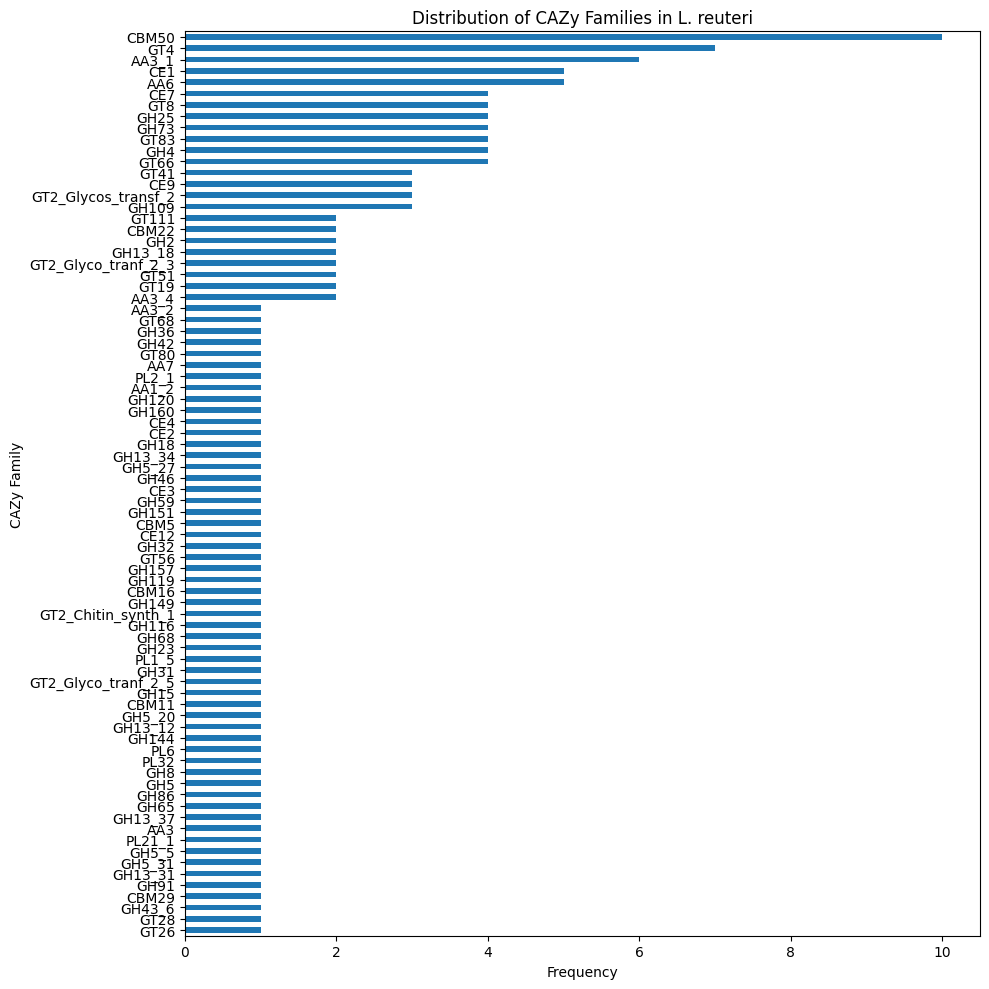

In [33]:
# The labels are overlapping, so we can adjust the figure size to make the plot more readable
plt.figure(figsize=(10, 10))
cazy_family_counts_sorted.plot(kind='barh')
plt.xlabel('Frequency')
plt.ylabel('CAZy Family')
plt.title('Distribution of CAZy Families in L. reuteri')
plt.tight_layout()
plt.show()
